In [2]:
import pandas as pd
import numpy as np
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
from math import radians, sin, cos, sqrt, atan2
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GridSearchCV
from scipy.spatial.distance import pdist, squareform
import dask.array as da
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from math import radians, sin, cos, sqrt, atan2
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from joblib import Parallel, delayed
from statsmodels.tsa.seasonal import seasonal_decompose


#Extra settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings("ignore")

In [3]:
#Loading train and test data
try:
    train_df=pd.read_csv('/home/anuragverma/Desktop/Kaggle/GeoAI Ground-level NO2 _Zindi/Datasets/Train.csv')
    test_df=pd.read_csv('/home/anuragverma/Desktop/Kaggle/GeoAI Ground-level NO2 _Zindi/Datasets/Test.csv')
    print("Train df shape: " ,train_df.shape)
    print("Test df shape: ", test_df.shape)

except FileNotFoundError:
    print('File not loaded')

Train df shape:  (86584, 14)
Test df shape:  (6576, 13)


In [4]:
#filling up na in numeric cols
train_df_benchmark_num=train_df.select_dtypes(include='number')
test_df_benchmark_num=test_df.select_dtypes(include='number')
train_df_benchmark_num.fillna(0,inplace=True)
test_df_benchmark_num.fillna(0,inplace=True)

In [5]:
#GT_NO2 is dependent variable 
train_df_benchmark_num_dependent=train_df_benchmark_num['GT_NO2']
train_df_benchmark_num=train_df_benchmark_num.drop('GT_NO2',axis=1)

train_df_benchmark_num_dependent.head()

0    31.0
1    42.0
2    31.0
3    30.0
4    58.0
Name: GT_NO2, dtype: float64

In [6]:
#Creating linear regression model
model= LinearRegression()
model.fit(train_df_benchmark_num,train_df_benchmark_num_dependent)


LinearRegression()

In [7]:
y_pred_benchmark=model.predict(test_df_benchmark_num)

#Add additional Id_Zindi to y_pred_benchmark and create df
y_pred_benchmark_df=pd.DataFrame(y_pred_benchmark,columns=['GT_NO2'])
benchmark_result_df=pd.concat([test_df['ID_Zindi'], y_pred_benchmark_df], axis=1)
benchmark_result_df.to_csv('/home/anuragverma/Desktop/Kaggle/GeoAI Ground-level NO2 _Zindi/Benchmark_model.csv',index=False)
#This gave 86 rank and score :10.7677807 in leaderboard

In [8]:
#Model2
#Now lets do this and check if it improves the model or not :1) Filled 25% null in NO2_trop doing NO2_TOTAL minus NO2_STRAT
train_model2_df=train_df.copy()
test_model2_df=test_df.copy()
train_model2_df=train_model2_df.select_dtypes(include='number')
test_model2_df=test_model2_df.select_dtypes(include='number')

In [9]:
train_model2_df['NO2_trop'] = train_model2_df.apply(
    lambda row: row['NO2_total'] - row['NO2_strat'] if pd.isna(row['NO2_trop']) else row['NO2_trop'],
    axis=1
)

test_model2_df['NO2_trop'] = test_model2_df.apply(
    lambda row: row['NO2_total'] - row['NO2_strat'] if pd.isna(row['NO2_trop']) else row['NO2_trop'],
    axis=1
)

# train_model2_df.columns

In [10]:
#Filling remaining null values with 0

train_model2_df.fillna(0,inplace=True)
test_model2_df.fillna(0,inplace=True)
train_model2_df_dependent=train_model2_df['GT_NO2']
train_model2_df=train_model2_df.drop('GT_NO2',axis=1)

In [11]:
#Creating model 2 prediction
model2=LinearRegression()
model2.fit(train_model2_df,train_model2_df_dependent)
y_pred_model2=model2.predict(test_model2_df)

#Add additional Id_Zindi to y_pred_benchmark and create df
y_pred_model2_df=pd.DataFrame(y_pred_model2,columns=['GT_NO2'])
model2_result_df=pd.concat([test_df['ID_Zindi'], y_pred_model2_df], axis=1)
model2_result_df.to_csv('/home/anuragverma/Desktop/Kaggle/GeoAI Ground-level NO2 _Zindi/model2.csv',index=False)
#This made it worse: 10.87  We won't be doing this

In [12]:
train_df.isnull().sum()

ID_Zindi                  0
Date                      0
ID                        0
LAT                       0
LON                       0
Precipitation             0
LST                   39786
AAI                   12875
CloudFraction         12875
NO2_strat             12875
NO2_total             12875
NO2_trop              35473
TropopausePressure    12875
GT_NO2                 4533
dtype: int64

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86584 entries, 0 to 86583
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID_Zindi            86584 non-null  object 
 1   Date                86584 non-null  object 
 2   ID                  86584 non-null  object 
 3   LAT                 86584 non-null  float64
 4   LON                 86584 non-null  float64
 5   Precipitation       86584 non-null  float64
 6   LST                 46798 non-null  float64
 7   AAI                 73709 non-null  float64
 8   CloudFraction       73709 non-null  float64
 9   NO2_strat           73709 non-null  float64
 10  NO2_total           73709 non-null  float64
 11  NO2_trop            51111 non-null  float64
 12  TropopausePressure  73709 non-null  float64
 13  GT_NO2              82051 non-null  float64
dtypes: float64(11), object(3)
memory usage: 9.2+ MB


In [14]:
#Model 3
train_model3_df=train_df.copy()
test_model3_df=test_df.copy()

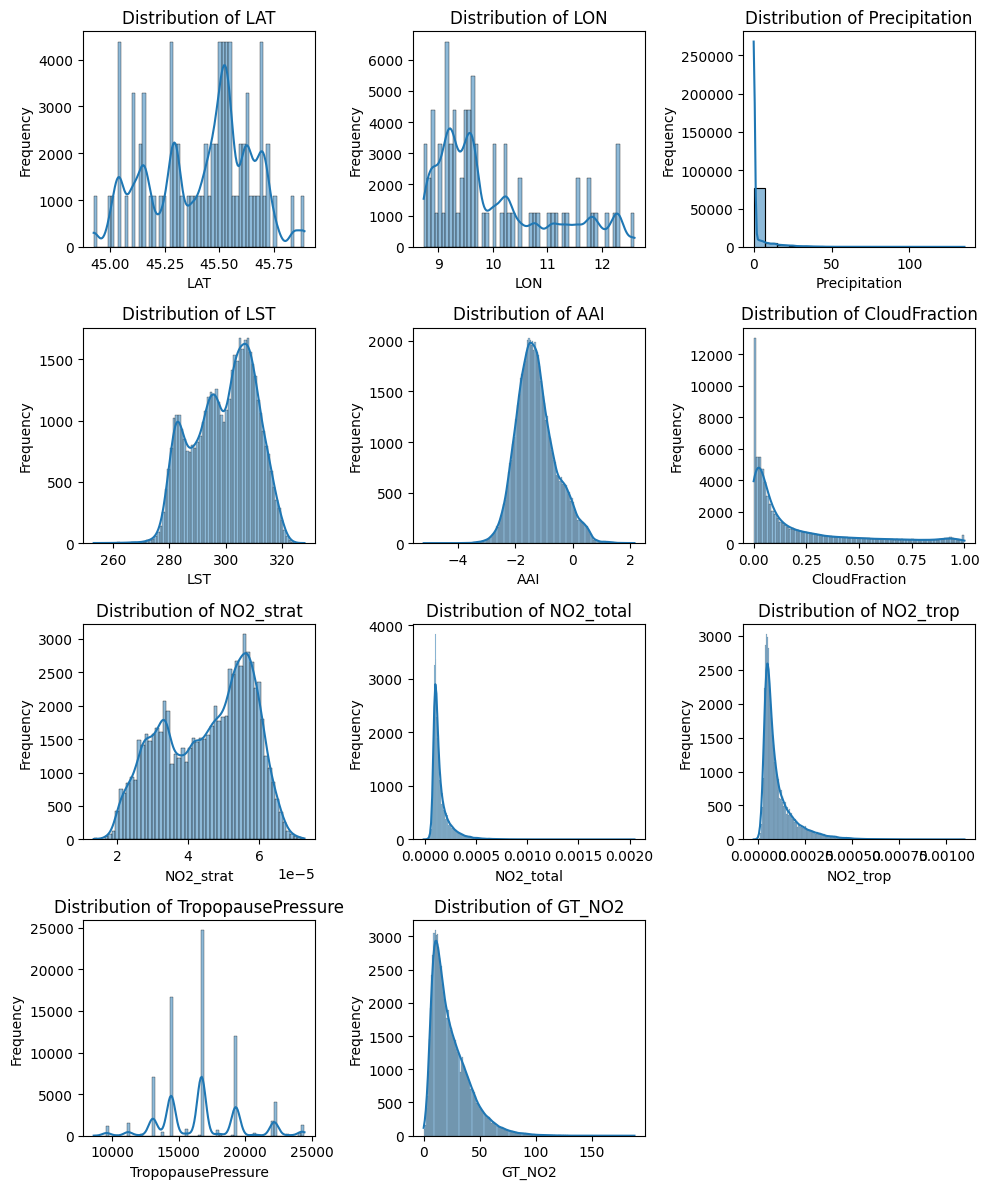

In [15]:
# Identify numeric columns
numeric_cols = train_model3_df.select_dtypes(include=['number']).columns

# Determine the number of rows and columns for subplots
n_cols = 3  # Set the number of columns to 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols  # Adjust the number of rows based on the number of columns

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3 * n_rows))
axes = axes.flatten()  # Flatten the array to easily iterate over axes

# Create distribution plots for each numeric column
for i, col in enumerate(numeric_cols):
    sns.histplot(train_model3_df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots
for i in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
plt.show()

In [16]:
train_model3_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86584 entries, 0 to 86583
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID_Zindi            86584 non-null  object 
 1   Date                86584 non-null  object 
 2   ID                  86584 non-null  object 
 3   LAT                 86584 non-null  float64
 4   LON                 86584 non-null  float64
 5   Precipitation       86584 non-null  float64
 6   LST                 46798 non-null  float64
 7   AAI                 73709 non-null  float64
 8   CloudFraction       73709 non-null  float64
 9   NO2_strat           73709 non-null  float64
 10  NO2_total           73709 non-null  float64
 11  NO2_trop            51111 non-null  float64
 12  TropopausePressure  73709 non-null  float64
 13  GT_NO2              82051 non-null  float64
dtypes: float64(11), object(3)
memory usage: 9.2+ MB


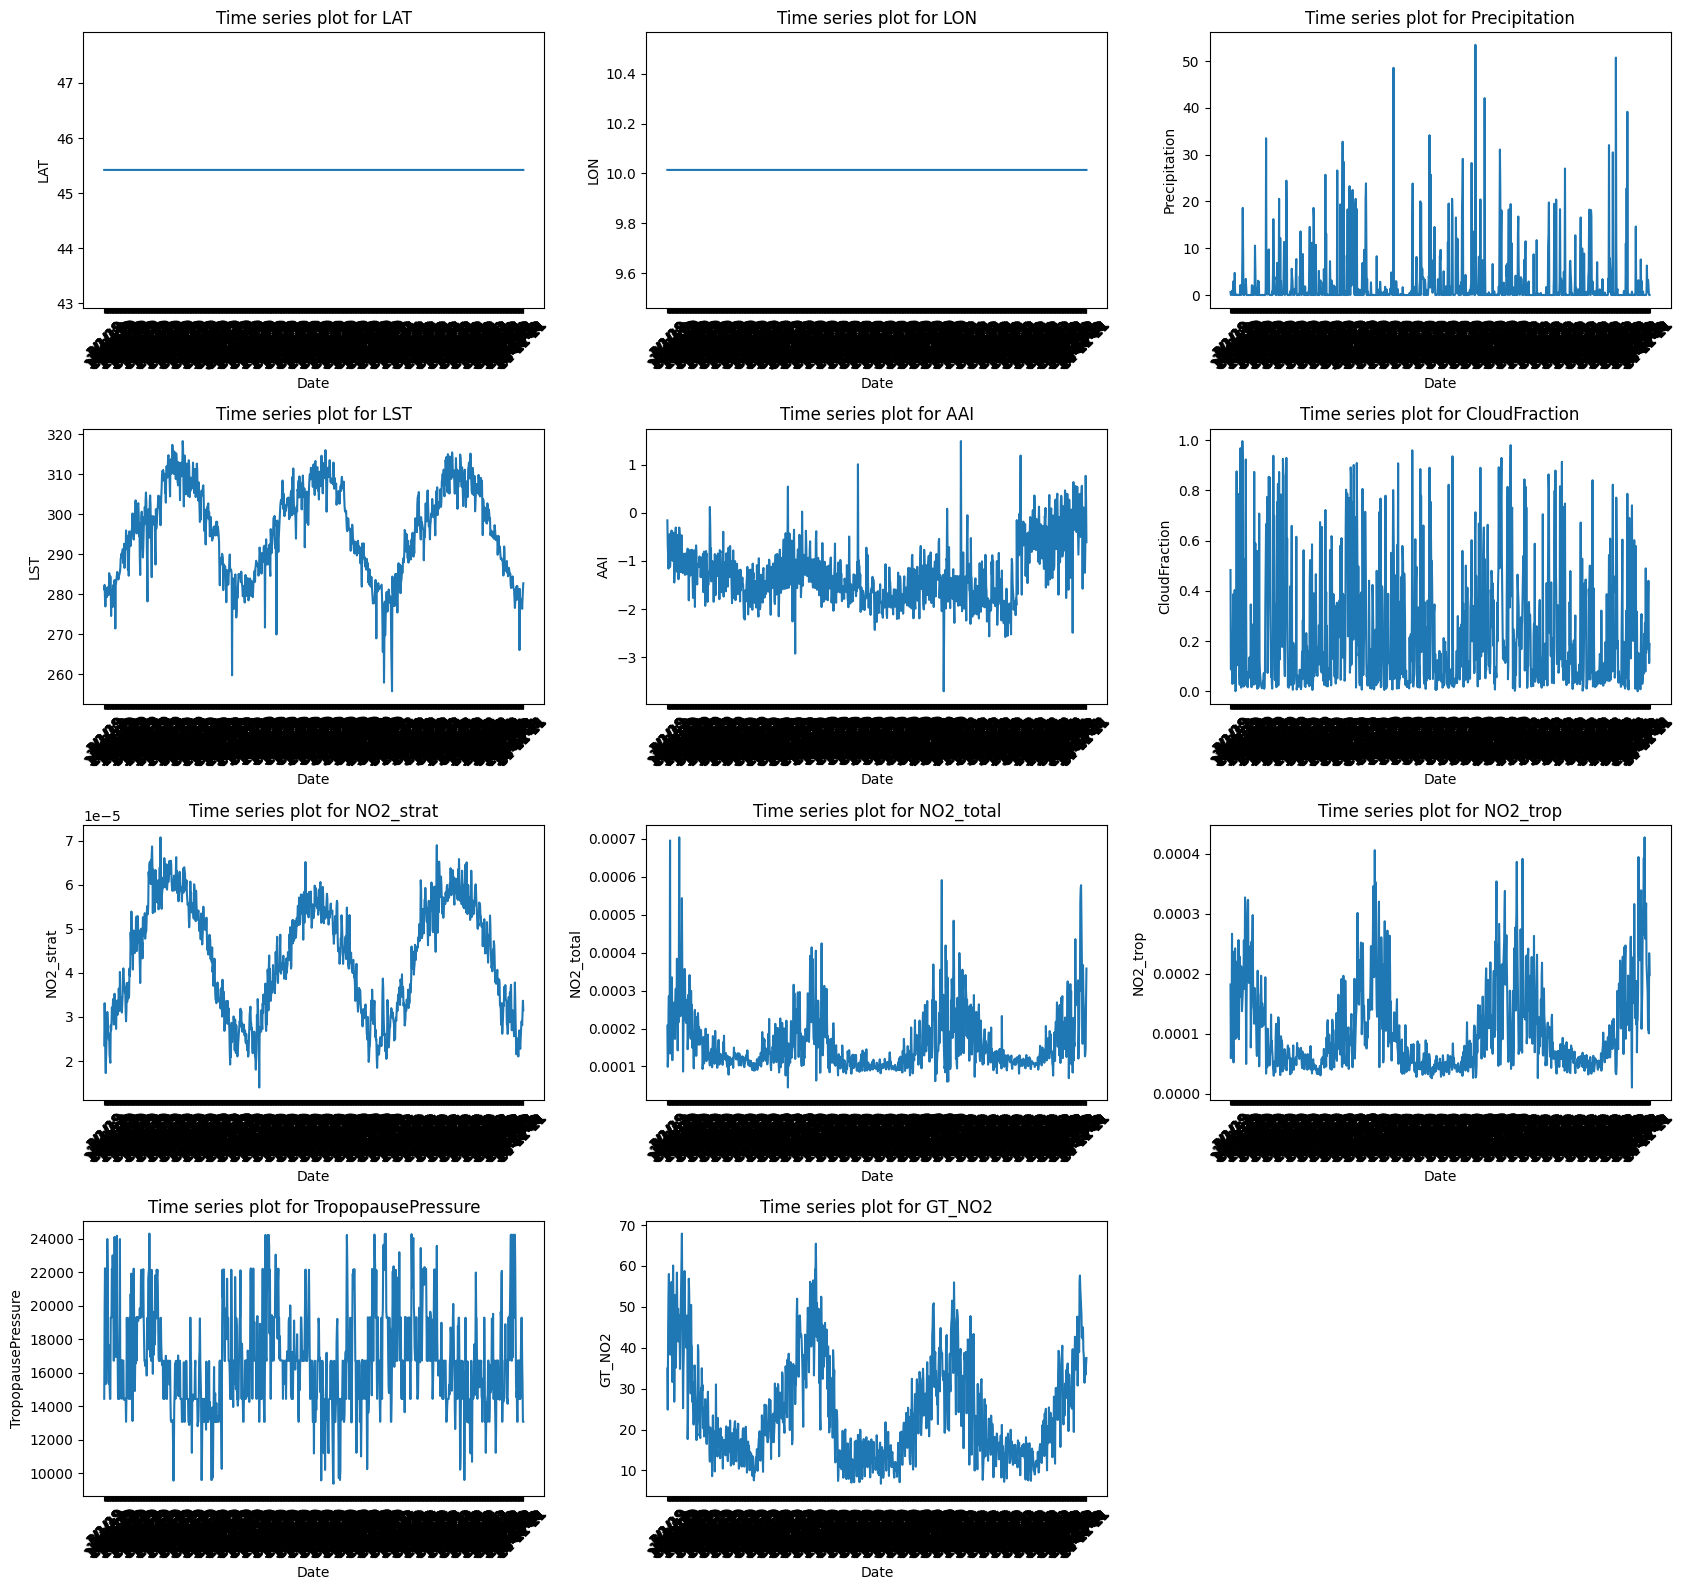

In [17]:
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(17, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.lineplot(x='Date', y=col, data=train_model3_df, ax=axes[i],ci=None)
    axes[i].set_title(f'Time series plot for {col}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(col)

 # Rotate x-axis labels
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

# Hide extra subplots if any
for j in range(len(numeric_cols), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [18]:
train_model3_df.head(5)

,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2
0,ID_ENTGC7,1/1/19,PD01,45.601585,11.903551,0.000000,NaN,0.230527,0.559117,0.000024,0.000117,NaN,14440.82126,31.0
1,ID_8JCCXC,1/1/19,PD04,45.371005,11.840830,3.047342,NaN,-0.074006,0.869309,0.000024,0.000127,NaN,14441.79815,42.0
2,ID_V3136Z,1/1/19,RO01,45.045825,12.060869,0.000000,NaN,0.024470,0.674160,0.000024,0.000086,NaN,14437.38294,31.0
3,ID_KRVZDJ,1/1/19,RO02,45.104075,11.553241,1.200467,NaN,-0.010442,0.920054,0.000024,0.000124,NaN,14440.83831,30.0
4,ID_PR351A,1/1/19,RO03,45.038758,11.790152,1.274564,NaN,-0.176178,0.747464,0.000024,0.000116,NaN,14438.79037,58.0


In [19]:
train_model3_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86584 entries, 0 to 86583
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID_Zindi            86584 non-null  object 
 1   Date                86584 non-null  object 
 2   ID                  86584 non-null  object 
 3   LAT                 86584 non-null  float64
 4   LON                 86584 non-null  float64
 5   Precipitation       86584 non-null  float64
 6   LST                 46798 non-null  float64
 7   AAI                 73709 non-null  float64
 8   CloudFraction       73709 non-null  float64
 9   NO2_strat           73709 non-null  float64
 10  NO2_total           73709 non-null  float64
 11  NO2_trop            51111 non-null  float64
 12  TropopausePressure  73709 non-null  float64
 13  GT_NO2              82051 non-null  float64
dtypes: float64(11), object(3)
memory usage: 9.2+ MB


In [20]:
train_model3_df.isnull().sum()

ID_Zindi                  0
Date                      0
ID                        0
LAT                       0
LON                       0
Precipitation             0
LST                   39786
AAI                   12875
CloudFraction         12875
NO2_strat             12875
NO2_total             12875
NO2_trop              35473
TropopausePressure    12875
GT_NO2                 4533
dtype: int64

In [21]:
#Linear interpolcation first
def Prep(df1):
    df=df1.copy()
    numeric_columns = df.select_dtypes(include=['number']).columns
    
    for col in numeric_columns:
        # Fill missing values temporarily using linear interpolation
        data_interpolated = df[col].interpolate(method='linear')
        
        # Handle cases where interpolation might still leave NaNs at the ends
        if data_interpolated.isna().sum() > 0:
            data_interpolated.fillna(method='bfill', inplace=True)
            data_interpolated.fillna(method='ffill', inplace=True)

        # Decompose the time series to extract the trend component
        decomposition = seasonal_decompose(data_interpolated, model='additive', period=30)
        trend = decomposition.trend
        
        # Handle cases where the trend might still have NaNs at the ends
        trend.fillna(method='bfill', inplace=True)
        trend.fillna(method='ffill', inplace=True)

        # Replace original NaN values with the trend component
        df[col] = df[col].combine_first(trend)
        
        # Fill any remaining NaN values with the mean of the column
        df[col].fillna(value=df[col].mean(),inplace=True)

    return df

In [22]:
train_model3_df.head(5)

,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2
0,ID_ENTGC7,1/1/19,PD01,45.601585,11.903551,0.000000,NaN,0.230527,0.559117,0.000024,0.000117,NaN,14440.82126,31.0
1,ID_8JCCXC,1/1/19,PD04,45.371005,11.840830,3.047342,NaN,-0.074006,0.869309,0.000024,0.000127,NaN,14441.79815,42.0
2,ID_V3136Z,1/1/19,RO01,45.045825,12.060869,0.000000,NaN,0.024470,0.674160,0.000024,0.000086,NaN,14437.38294,31.0
3,ID_KRVZDJ,1/1/19,RO02,45.104075,11.553241,1.200467,NaN,-0.010442,0.920054,0.000024,0.000124,NaN,14440.83831,30.0
4,ID_PR351A,1/1/19,RO03,45.038758,11.790152,1.274564,NaN,-0.176178,0.747464,0.000024,0.000116,NaN,14438.79037,58.0


In [23]:
test_model2_df.head(5)

,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure
0,45.289376,11.642394,3.277529,0.00,-0.313361,0.771456,0.000024,0.000075,0.000051,14440.02819
1,45.836941,12.510362,0.000000,0.00,-0.229512,0.398208,0.000023,0.000120,0.000097,14434.04790
2,45.582894,8.842165,0.000000,282.98,-0.470822,0.153694,0.000023,0.000171,0.000148,14427.42478
3,45.131947,10.015742,1.928031,0.00,0.132952,0.756917,0.000024,0.000266,0.000242,14443.09006
4,45.186329,9.146666,0.000000,0.00,-0.198272,0.678858,0.000023,0.000149,0.000125,14440.85840


In [24]:
train_model3_df_prep=Prep(train_model3_df)
test_model3_df_prep=Prep(test_model3_df)

In [25]:
train_model3_df_prep.isnull().sum()

ID_Zindi              0
Date                  0
ID                    0
LAT                   0
LON                   0
Precipitation         0
LST                   0
AAI                   0
CloudFraction         0
NO2_strat             0
NO2_total             0
NO2_trop              0
TropopausePressure    0
GT_NO2                0
dtype: int64

In [26]:
test_model3_df_prep.isnull().sum()

ID_Zindi              0
Date                  0
ID                    0
LAT                   0
LON                   0
Precipitation         0
LST                   0
AAI                   0
CloudFraction         0
NO2_strat             0
NO2_total             0
NO2_trop              0
TropopausePressure    0
dtype: int64

In [27]:
train_model3_df_prep.head(5)

,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2
0,ID_ENTGC7,1/1/19,PD01,45.601585,11.903551,0.000000,280.097333,0.230527,0.559117,0.000024,0.000117,0.000136,14440.82126,31.0
1,ID_8JCCXC,1/1/19,PD04,45.371005,11.840830,3.047342,280.097333,-0.074006,0.869309,0.000024,0.000127,0.000136,14441.79815,42.0
2,ID_V3136Z,1/1/19,RO01,45.045825,12.060869,0.000000,280.097333,0.024470,0.674160,0.000024,0.000086,0.000136,14437.38294,31.0
3,ID_KRVZDJ,1/1/19,RO02,45.104075,11.553241,1.200467,280.097333,-0.010442,0.920054,0.000024,0.000124,0.000136,14440.83831,30.0
4,ID_PR351A,1/1/19,RO03,45.038758,11.790152,1.274564,280.097333,-0.176178,0.747464,0.000024,0.000116,0.000136,14438.79037,58.0


In [28]:
train_model3_df_prep=train_model3_df_prep.select_dtypes(include=['number'])
test_model3_df_prep=test_model3_df_prep.select_dtypes(include=['number'])


In [29]:
train_model3_df_prep_GT_NO2=train_model3_df_prep['GT_NO2']
train_model3_df_prep=train_model3_df_prep.drop('GT_NO2',axis=1)

In [30]:
#Creating model 3
model3=LinearRegression()
model3.fit(train_model3_df_prep,train_model3_df_prep_GT_NO2)
y_pred3=model3.predict(test_model3_df_prep)

In [31]:

#Add additional Id_Zindi to y_pred_benchmark and create df
y_pred3_df=pd.DataFrame(y_pred3,columns=['GT_NO2'])
model3_result_df=pd.concat([test_df['ID_Zindi'], y_pred3_df], axis=1)
model3_result_df.to_csv('/home/anuragverma/Desktop/Kaggle/GeoAI Ground-level NO2 _Zindi/model3.csv',index=False)
#Best till now 10.73


In [32]:
#Testing cubic interpolcation second

def Prep_cubic(df1):
    df=df1.copy()
    numeric_columns = df.select_dtypes(include=['number']).columns
    
    for col in numeric_columns:
        # Fill missing values temporarily using linear interpolation
        data_interpolated = df[col].interpolate(method='cubic')
        
        # Handle cases where interpolation might still leave NaNs at the ends
        if data_interpolated.isna().sum() > 0:
            data_interpolated.fillna(method='bfill', inplace=True)
            data_interpolated.fillna(method='ffill', inplace=True)

        # Decompose the time series to extract the trend component
        decomposition = seasonal_decompose(data_interpolated, model='additive', period=30)
        trend = decomposition.trend
        
        # Handle cases where the trend might still have NaNs at the ends
        trend.fillna(method='bfill', inplace=True)
        trend.fillna(method='ffill', inplace=True)

        # Replace original NaN values with the trend component
        df[col] = df[col].combine_first(trend)
        
        # Fill any remaining NaN values with the mean of the column
        df[col].fillna(value=df[col].mean(),inplace=True)

    return df

In [33]:
train_model3_df_prep_cubic=Prep_cubic(train_model3_df)
test_model3_df_prep_cubic=Prep_cubic(test_model3_df)

In [34]:
# Select only numeric columns for both train and test datasets
train_model3_df_prep_cubic = train_model3_df_prep_cubic.select_dtypes(include=['number'])
test_model3_df_prep_cubic = test_model3_df_prep_cubic.select_dtypes(include=['number'])

# Separate the target variable 'GT_NO2' from the features in the training dataset
train_model3_df_prep_GT_NO2_cubic = train_model3_df_prep_cubic['GT_NO2']
train_model3_df_prep_cubic = train_model3_df_prep_cubic.drop('GT_NO2', axis=1)

# Creating model 3 using Linear Regression
from sklearn.linear_model import LinearRegression

model3 = LinearRegression()
model3.fit(train_model3_df_prep_cubic, train_model3_df_prep_GT_NO2_cubic)

# Predict using the test dataset
y_pred3 = model3.predict(test_model3_df_prep_cubic)

# Add additional 'ID_Zindi' to y_pred3 and create a DataFrame
y_pred3_df = pd.DataFrame(y_pred3, columns=['GT_NO2'])
model3_result_df = pd.concat([test_df['ID_Zindi'], y_pred3_df], axis=1)

# Save the results to a CSV file
model3_result_df.to_csv('/home/anuragverma/Desktop/Kaggle/GeoAI Ground-level NO2 _Zindi/model3_cubic.csv', index=False)
#Model became worse: 11.34841464 we will stick to linear interpolation

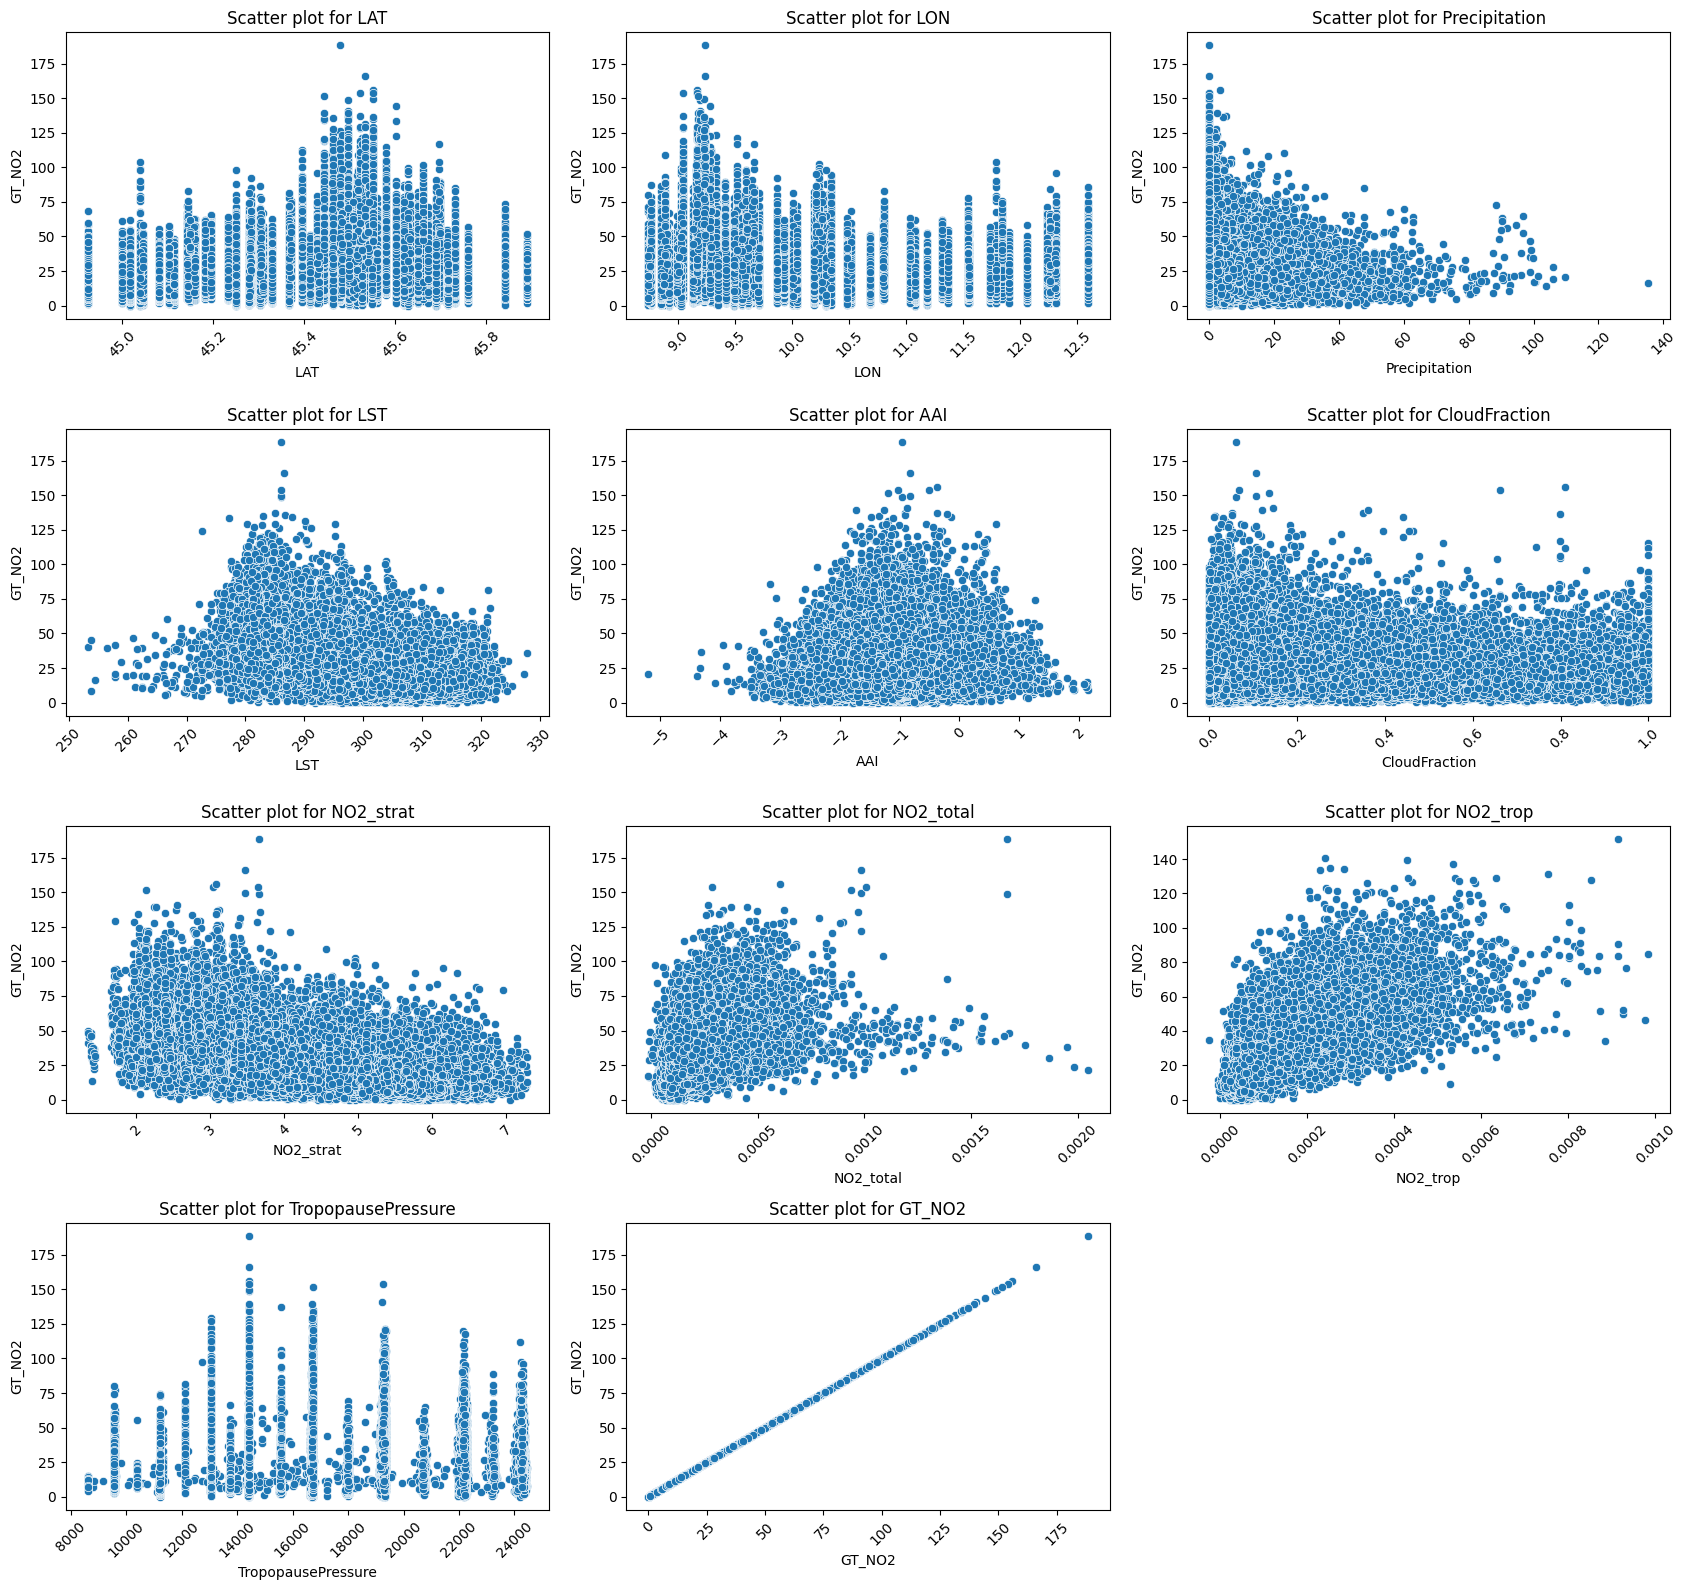

In [35]:
#Scatter plot
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(17, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.scatterplot(x=col, y='GT_NO2', data=train_model3_df, ax=axes[i])
    axes[i].set_title(f'Scatter plot for {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('GT_NO2')

 # Rotate x-axis labels
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

# Hide extra subplots if any
for j in range(len(numeric_cols), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [36]:
#Trying to fix missing values using 

In [37]:

def Prep_linear(df1):
    df=df1.copy()
    numeric_columns =['Precipitation','LST','AAI','CloudFraction','TropopausePressure','GT_NO2']
    
    for col in numeric_columns:
        # Fill missing values temporarily using linear interpolation
        data_interpolated = df[col].interpolate(method='linear')
        
        # Handle cases where interpolation might still leave NaNs at the ends
        if data_interpolated.isna().sum() > 0:
            data_interpolated.fillna(method='bfill', inplace=True)
            data_interpolated.fillna(method='ffill', inplace=True)

        # Decompose the time series to extract the trend component
        decomposition = seasonal_decompose(data_interpolated, model='additive', period=30)
        trend = decomposition.trend
        
        # Handle cases where the trend might still have NaNs at the ends
        trend.fillna(method='bfill', inplace=True)
        trend.fillna(method='ffill', inplace=True)

        # Replace original NaN values with the trend component
        df[col] = df[col].combine_first(trend)
        
        # Fill any remaining NaN values with the mean of the column
        df[col].fillna(value=df[col].mean(),inplace=True)

    return df



def Prep_spline(df1):
    df=df1.copy()
    numeric_columns =['NO2_strat','NO2_total','NO2_trop']
    
    for col in numeric_columns:
        # Fill missing values temporarily using linear interpolation
        data_interpolated = df[col].interpolate(method='spline',order=2)
        
        # Handle cases where interpolation might still leave NaNs at the ends
        if data_interpolated.isna().sum() > 0:
            data_interpolated.fillna(method='bfill', inplace=True)
            data_interpolated.fillna(method='ffill', inplace=True)

        # Decompose the time series to extract the trend component
        decomposition = seasonal_decompose(data_interpolated, model='additive', period=30)
        trend = decomposition.trend
        
        # Handle cases where the trend might still have NaNs at the ends
        trend.fillna(method='bfill', inplace=True)
        trend.fillna(method='ffill', inplace=True)

        # Replace original NaN values with the trend component
        df[col] = df[col].combine_first(trend)
        
        # Fill any remaining NaN values with the mean of the column
        df[col].fillna(value=df[col].mean(),inplace=True)

    return df

In [38]:
def Prep_linear_test(df1):
    df=df1.copy()
    numeric_columns =['Precipitation','LST','AAI','CloudFraction','TropopausePressure']
    
    for col in numeric_columns:
        # Fill missing values temporarily using linear interpolation
        data_interpolated = df[col].interpolate(method='linear')
        
        # Handle cases where interpolation might still leave NaNs at the ends
        if data_interpolated.isna().sum() > 0:
            data_interpolated.fillna(method='bfill', inplace=True)
            data_interpolated.fillna(method='ffill', inplace=True)

        # Decompose the time series to extract the trend component
        decomposition = seasonal_decompose(data_interpolated, model='additive', period=30)
        trend = decomposition.trend
        
        # Handle cases where the trend might still have NaNs at the ends
        trend.fillna(method='bfill', inplace=True)
        trend.fillna(method='ffill', inplace=True)

        # Replace original NaN values with the trend component
        df[col] = df[col].combine_first(trend)
        
        # Fill any remaining NaN values with the mean of the column
        df[col].fillna(value=df[col].mean(),inplace=True)

    return df

#Testing cubic interpolcation second


In [39]:
train_model3_df.head(5)

,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2
0,ID_ENTGC7,1/1/19,PD01,45.601585,11.903551,0.000000,NaN,0.230527,0.559117,0.000024,0.000117,NaN,14440.82126,31.0
1,ID_8JCCXC,1/1/19,PD04,45.371005,11.840830,3.047342,NaN,-0.074006,0.869309,0.000024,0.000127,NaN,14441.79815,42.0
2,ID_V3136Z,1/1/19,RO01,45.045825,12.060869,0.000000,NaN,0.024470,0.674160,0.000024,0.000086,NaN,14437.38294,31.0
3,ID_KRVZDJ,1/1/19,RO02,45.104075,11.553241,1.200467,NaN,-0.010442,0.920054,0.000024,0.000124,NaN,14440.83831,30.0
4,ID_PR351A,1/1/19,RO03,45.038758,11.790152,1.274564,NaN,-0.176178,0.747464,0.000024,0.000116,NaN,14438.79037,58.0


In [40]:
train_model3_df_prep_mix=Prep_linear(train_model3_df)
train_model3_df_prep_mix=Prep_spline(train_model3_df_prep_mix)

test_model3_df_prep_mix=Prep_linear_test(test_model3_df)
test_model3_df_prep_mix=Prep_spline(test_model3_df_prep_mix)


In [41]:
train_model3_df.head(5)

,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2
0,ID_ENTGC7,1/1/19,PD01,45.601585,11.903551,0.000000,NaN,0.230527,0.559117,0.000024,0.000117,NaN,14440.82126,31.0
1,ID_8JCCXC,1/1/19,PD04,45.371005,11.840830,3.047342,NaN,-0.074006,0.869309,0.000024,0.000127,NaN,14441.79815,42.0
2,ID_V3136Z,1/1/19,RO01,45.045825,12.060869,0.000000,NaN,0.024470,0.674160,0.000024,0.000086,NaN,14437.38294,31.0
3,ID_KRVZDJ,1/1/19,RO02,45.104075,11.553241,1.200467,NaN,-0.010442,0.920054,0.000024,0.000124,NaN,14440.83831,30.0
4,ID_PR351A,1/1/19,RO03,45.038758,11.790152,1.274564,NaN,-0.176178,0.747464,0.000024,0.000116,NaN,14438.79037,58.0


In [42]:
train_model3_df_prep_mix.isnull().sum()

ID_Zindi              0
Date                  0
ID                    0
LAT                   0
LON                   0
Precipitation         0
LST                   0
AAI                   0
CloudFraction         0
NO2_strat             0
NO2_total             0
NO2_trop              0
TropopausePressure    0
GT_NO2                0
dtype: int64

In [43]:
# Select only numeric columns for both train and test datasets
train_model3_df_prep_mix = train_model3_df_prep_mix.select_dtypes(include=['number'])
test_model3_df_prep_mix = test_model3_df_prep_mix.select_dtypes(include=['number'])

# Separate the target variable 'GT_NO2' from the features in the training dataset
train_model3_df_prep_mix_GT_NO2_mix = train_model3_df_prep_mix['GT_NO2']
train_model3_df_prep_mix = train_model3_df_prep_mix.drop('GT_NO2', axis=1)

In [44]:
model3_mix = LinearRegression()
model3_mix.fit(train_model3_df_prep_mix, train_model3_df_prep_mix_GT_NO2_mix)

# Predict using the test dataset
y_pred3_mix = model3_mix.predict(test_model3_df_prep_mix)

# Add additional 'ID_Zindi' to y_pred3 and create a DataFrame
y_pred3_mix_df = pd.DataFrame(y_pred3_mix, columns=['GT_NO2'])
model3_mix_result_df = pd.concat([test_df['ID_Zindi'], y_pred3_mix_df], axis=1)

# Save the results to a CSV file
model3_mix_result_df.to_csv('/home/anuragverma/Desktop/Kaggle/GeoAI Ground-level NO2 _Zindi/model3_mix.csv', index=False)
#Best till now: 10.72134503

In [45]:
train_model3_df_prep_mix.head(5)

,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure
0,45.601585,11.903551,0.000000,280.097333,0.230527,0.559117,0.000024,0.000117,0.000131,14440.82126
1,45.371005,11.840830,3.047342,280.097333,-0.074006,0.869309,0.000024,0.000127,0.000131,14441.79815
2,45.045825,12.060869,0.000000,280.097333,0.024470,0.674160,0.000024,0.000086,0.000131,14437.38294
3,45.104075,11.553241,1.200467,280.097333,-0.010442,0.920054,0.000024,0.000124,0.000131,14440.83831
4,45.038758,11.790152,1.274564,280.097333,-0.176178,0.747464,0.000024,0.000116,0.000131,14438.79037


In [46]:
#Doing one more interation with mix 

def Prep_linear_mix(df1):
    df=df1.copy()
    
    numeric_columns =['NO2_strat','NO2_total','NO2_trop','Precipitation','GT_NO2']
    
    for col in numeric_columns:
        # Fill missing values temporarily using linear interpolation
        data_interpolated = df[col].interpolate(method='linear')
        
        # Handle cases where interpolation might still leave NaNs at the ends
        if data_interpolated.isna().sum() > 0:
            data_interpolated.fillna(method='bfill', inplace=True)
            data_interpolated.fillna(method='ffill', inplace=True)

        # Decompose the time series to extract the trend component
        decomposition = seasonal_decompose(data_interpolated, model='additive', period=30)
        trend = decomposition.trend
        
        # Handle cases where the trend might still have NaNs at the ends
        trend.fillna(method='bfill', inplace=True)
        trend.fillna(method='ffill', inplace=True)

        # Replace original NaN values with the trend component
        df[col] = df[col].combine_first(trend)
        
        # Fill any remaining NaN values with the mean of the column
        df[col].fillna(value=df[col].mean(),inplace=True)

    return df

def Prep_linear_test_mix(df1):
    df=df1.copy()
    
    numeric_columns =['NO2_strat','NO2_total','NO2_trop','Precipitation']
    
    for col in numeric_columns:
        # Fill missing values temporarily using linear interpolation
        data_interpolated = df[col].interpolate(method='linear')
        
        # Handle cases where interpolation might still leave NaNs at the ends
        if data_interpolated.isna().sum() > 0:
            data_interpolated.fillna(method='bfill', inplace=True)
            data_interpolated.fillna(method='ffill', inplace=True)

        # Decompose the time series to extract the trend component
        decomposition = seasonal_decompose(data_interpolated, model='additive', period=30)
        trend = decomposition.trend
        
        # Handle cases where the trend might still have NaNs at the ends
        trend.fillna(method='bfill', inplace=True)
        trend.fillna(method='ffill', inplace=True)

        # Replace original NaN values with the trend component
        df[col] = df[col].combine_first(trend)
        
        # Fill any remaining NaN values with the mean of the column
        df[col].fillna(value=df[col].mean(),inplace=True)

    return df


def Prep_spline_mix(df1):
    df=df1.copy()
    numeric_columns =['LST','AAI','CloudFraction','TropopausePressure']
    
    for col in numeric_columns:
        # Fill missing values temporarily using linear interpolation
        data_interpolated = df[col].interpolate(method='spline',order=2)
        
        # Handle cases where interpolation might still leave NaNs at the ends
        if data_interpolated.isna().sum() > 0:
            data_interpolated.fillna(method='bfill', inplace=True)
            data_interpolated.fillna(method='ffill', inplace=True)

        # Decompose the time series to extract the trend component
        decomposition = seasonal_decompose(data_interpolated, model='additive', period=30)
        trend = decomposition.trend
        
        # Handle cases where the trend might still have NaNs at the ends
        trend.fillna(method='bfill', inplace=True)
        trend.fillna(method='ffill', inplace=True)

        # Replace original NaN values with the trend component
        df[col] = df[col].combine_first(trend)
        
        # Fill any remaining NaN values with the mean of the column
        df[col].fillna(value=df[col].mean(),inplace=True)

    return df

In [47]:
train_model3_df_prep_mix=Prep_linear_mix(train_model3_df)
train_model3_df_prep_mix=Prep_spline_mix(train_model3_df_prep_mix)

test_model3_df_prep_mix=Prep_linear_test_mix(test_model3_df)
test_model3_df_prep_mix=Prep_spline_mix(test_model3_df_prep_mix)

In [ ]:
train_model3_df_prep_mix.isnull().sum()

ID_Zindi              0
Date                  0
ID                    0
LAT                   0
LON                   0
Precipitation         0
LST                   0
AAI                   0
CloudFraction         0
NO2_strat             0
NO2_total             0
NO2_trop              0
TropopausePressure    0
GT_NO2                0
dtype: int64

In [ ]:


# Select only numeric columns for both train and test datasets
train_model3_df_prep_mix = train_model3_df_prep_mix.select_dtypes(include=['number'])
test_model3_df_prep_mix = test_model3_df_prep_mix.select_dtypes(include=['number'])

# Separate the target variable 'GT_NO2' from the features in the training dataset
train_model3_df_prep_mix_GT_NO2_mix = train_model3_df_prep_mix['GT_NO2']
train_model3_df_prep_mix = train_model3_df_prep_mix.drop('GT_NO2', axis=1)

model3_mix = LinearRegression()
model3_mix.fit(train_model3_df_prep_mix, train_model3_df_prep_mix_GT_NO2_mix)

# Predict using the test dataset
y_pred3_mix = model3_mix.predict(test_model3_df_prep_mix)

# Add additional 'ID_Zindi' to y_pred3 and create a DataFrame
y_pred3_mix_df = pd.DataFrame(y_pred3_mix, columns=['GT_NO2'])
model3_mix_result_df = pd.concat([test_df['ID_Zindi'], y_pred3_mix_df], axis=1)

# Save the results to a CSV file
model3_mix_result_df.to_csv('/home/anuragverma/Desktop/Kaggle/GeoAI Ground-level NO2 _Zindi/model3_mix4.csv', index=False)
#Gave 10.77309859